<a href="https://colab.research.google.com/github/MoeinDSP/Numerical-Analysis-for-Machine-Learning/blob/main/background_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background Removal
We aim to remove the background from a video and be able to select only the moving parts using SVD.

We use as benchmark the real video 003 dataset from BMC 2012 [Background Models Challenge Dataset](http://backgroundmodelschallenge.eu/)

In [1]:
!wget http://backgroundmodelschallenge.eu/data/real/Video_003.zip
!unzip Video_003.zip

--2025-04-13 22:21:32--  http://backgroundmodelschallenge.eu/data/real/Video_003.zip
Resolving backgroundmodelschallenge.eu (backgroundmodelschallenge.eu)... 145.239.37.162, 2001:41d0:301::30
Connecting to backgroundmodelschallenge.eu (backgroundmodelschallenge.eu)|145.239.37.162|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3279920 (3.1M) [application/zip]
Saving to: ‘Video_003.zip’

Video_003.zip       100%[===================>]   3.13M  3.78MB/s    in 0.8s    

2025-04-13 22:21:34 (3.78 MB/s) - ‘Video_003.zip’ saved [3279920/3279920]

Archive:  Video_003.zip
   creating: Video_003/
   creating: Video_003/img/
  inflating: Video_003/img/Img_00250.bmp  
  inflating: Video_003/img/Img_00251.bmp  
  inflating: Video_003/img/Img_00252.bmp  
  inflating: Video_003/img/Img_00350.bmp  
  inflating: Video_003/img/Img_00351.bmp  
  inflating: Video_003/img/Img_00352.bmp  
  inflating: Video_003/img/Img_00450.bmp  
  inflating: Video_003/img/Img_00451.bmp  
  inflati

Import needed libraries:

In [5]:
import moviepy.editor as mpe
import numpy as np
import skimage.transform

%matplotlib inline
import matplotlib.pyplot as plt

Load the video and check its duration

In [6]:
video = mpe.VideoFileClip("Video_003/Video_003.avi")
video.duration

113.57

Let us visualize the video, and actually check its contents

In [8]:
video.subclip(0, 10).ipython_display(width=500)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### Helper Methods
In order to work with the video, we need to implement a couple of helper methods:
- a method to tranform a color image into a gray image (SVD works with 2D matrices, thus, for sake of simplicity, we avoid repeating the same operations to each channel of the image by using a gray-scale image)
- a method to transform the video into a numpy matrix, we also downscale the video to reduce the computational cost of applying the SVD. We can unroll a frame into a single tall column. So instead of having a 2D picture, we have a column. This isn't very human-readable, but it's handy because it lets us stack the images from different times on top of one another, to put a video all into 1 matrix.

In [9]:
def create_data_matrix_from_video(clip, dims):
    number_of_frames = int(clip.fps * clip.duration)
    flatten_gray_frames = []
    for i in range(number_of_frames):
        # get_frame takes as input the time of the frame
        frame = clip.get_frame(i / clip.fps)
        # to gray scale
        gray_frame = np.mean(frame[..., :3], axis=-1).astype(int)
        # resize to reduce computational cost
        small_gray_frame = skimage.transform.resize(gray_frame, dims)
        # each frame becomes a column vector of A
        flatten_gray_frames.append(small_gray_frame.flatten())
    return np.vstack(flatten_gray_frames).T

We set some parameters and create the matrix



In [10]:
scale = 0.50   # Adjust scale to change resolution of image
width, height = video.size
dims = (int(height * scale), int(width * scale))
A = create_data_matrix_from_video(video, dims)
print("frame size:", dims)
print("video matrix size:", A.shape)

frame size: (120, 160)
video matrix size: (19200, 794)


Let's visualize the 140-th frame of the video (rescaled and decolored)

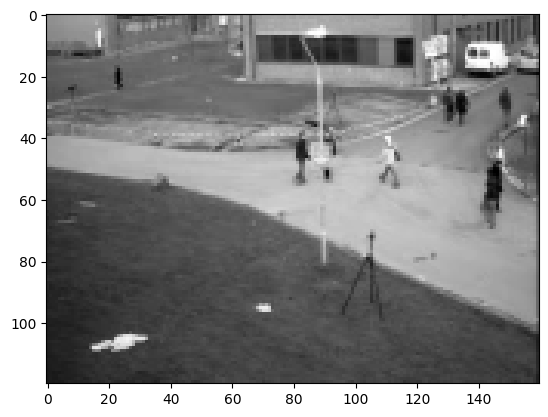

In [13]:
plt.imshow(np.reshape(A[:,140], dims), cmap='gray');

What does the matrix A look like instead?

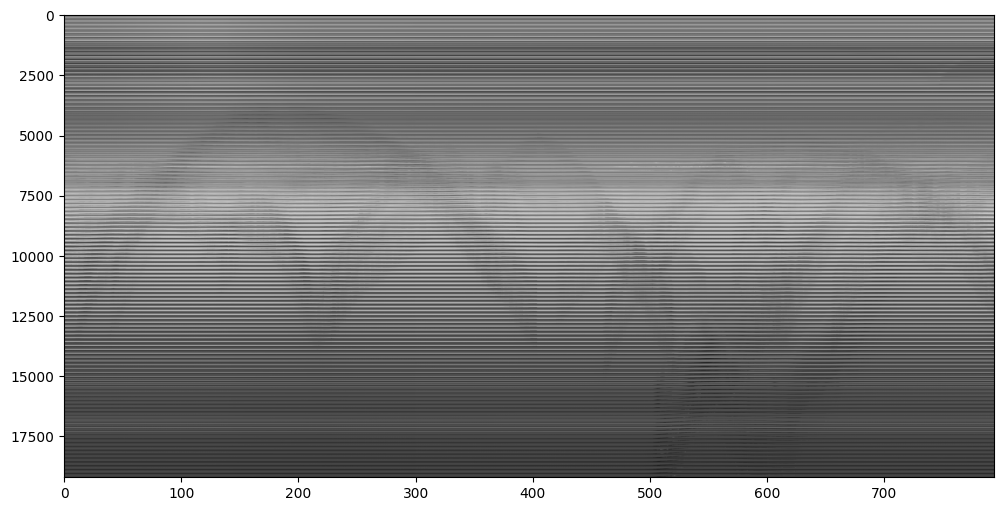

In [14]:
plt.figure(figsize=(12, 6))
plt.imshow(A, cmap='gray', aspect='auto');



```
# This is formatted as code
```


**Questions**: What are those wavy black lines? What are the horizontal lines?


## Apply the SVD
We apply the SVD to our matrix $A$

In [15]:
U, s, VT = np.linalg.svd(A, full_matrices=False)
U.shape, s.shape, VT.shape

((19200, 794), (794,), (794, 794))


Check that they are a decomposition of A

In [16]:
reconstructed_A = U @ np.diag(s) @ VT
np.allclose(A, reconstructed_A)

True

Since the background is more or less constant during the video (the horizontal lines of A), we suppose that the background can be reconstructed using few singular values

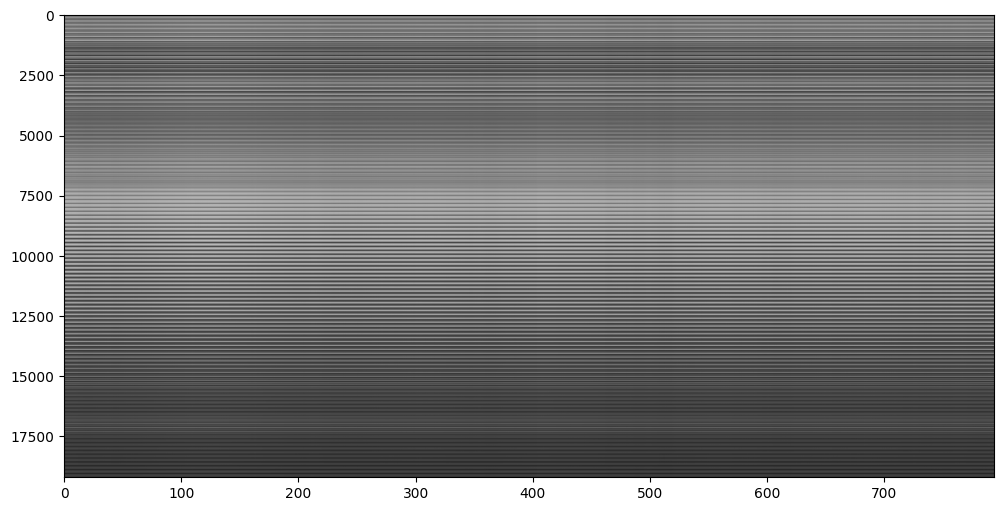

In [19]:
n_singular_values = 1
background = U[:,0:n_singular_values] * s[0] * VT[0:n_singular_values,:]
plt.figure(figsize=(12, 6))
plt.imshow(background, cmap='gray', aspect='auto')

The SVD has done all the heavy liflting!
Now we "just" have to visualize the results in a human comprehensible way.


Let's visualize the original video, the background and the foreground at some fixed instances in time.

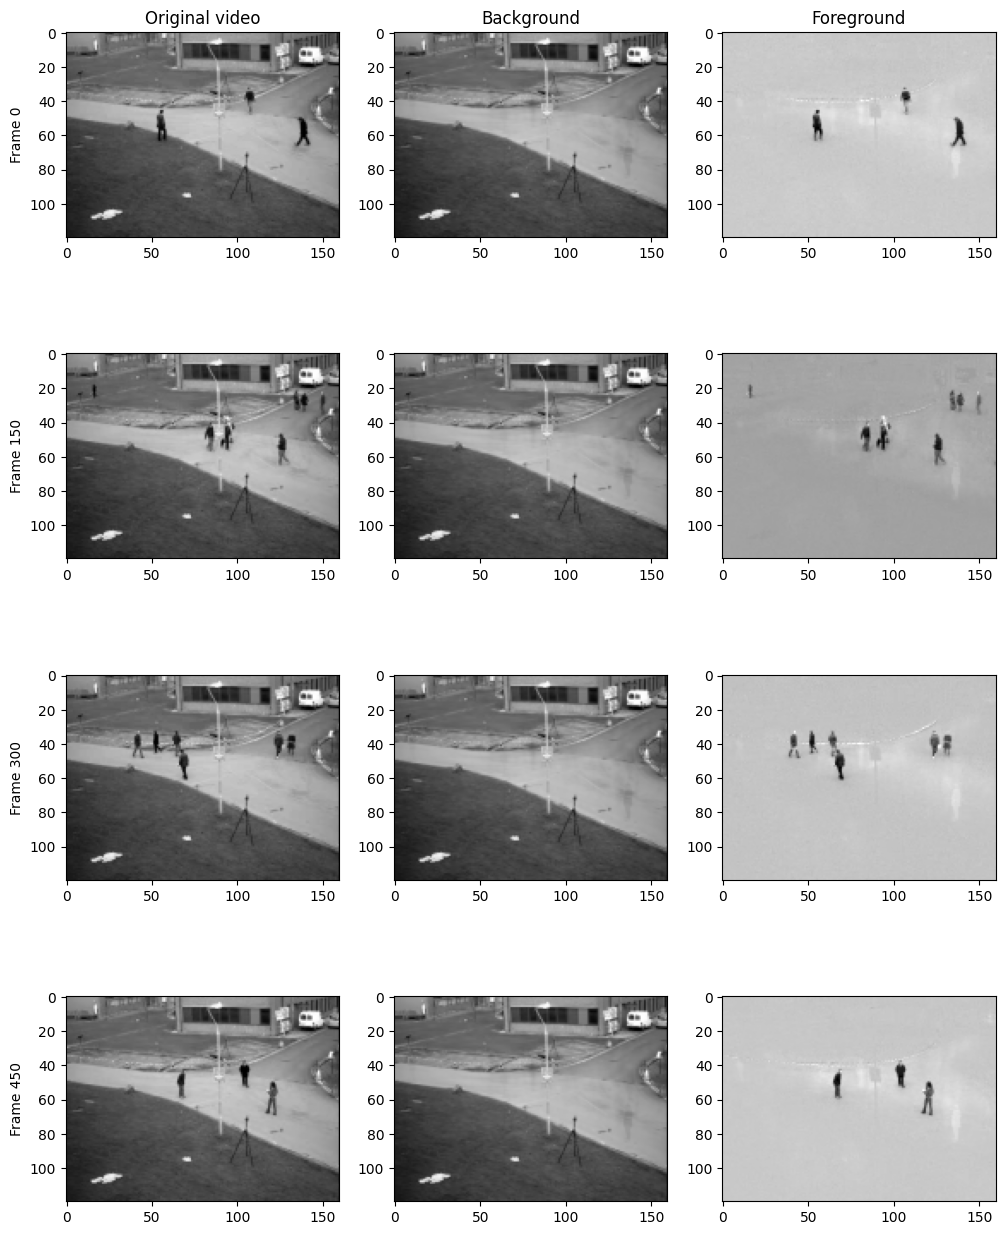

In [20]:
def plot_frames(A, background, time_ids):
  fig, axs = plt.subplots(len(time_ids), 3, figsize=(12, 4 * len(time_ids)))
  for i, t_id in enumerate(time_ids):
    axs[i, 0].imshow(np.reshape(A[:, t_id], dims), cmap='gray')
    axs[i, 1].imshow(np.reshape(background[:, t_id], dims), cmap='gray')
    axs[i, 2].imshow(np.reshape(A[:, t_id] - background[:, t_id], dims), cmap='gray')

    axs[i, 0].set_ylabel(f"Frame {t_id}")

    if i == 0:
      axs[0, 0].set_title("Original video")
      axs[0, 1].set_title("Background")
      axs[0, 2].set_title("Foreground")

time_ids = [0, 150, 300, 450]
plot_frames(A, background, time_ids)


What are the downsides?

SVD was really slow (remember that we also compressed our frames to reduce the computational cost). Moreover, we threw away a lot of our calculation, we used just one singular value.

